In [1]:
from scipy.special import spherical_jn as jn
from scipy.special import spherical_yn as yn
from scipy.special import lambertw as lamb
from scipy.misc import derivative
from scipy.interpolate import CubicSpline as CS
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
#from matplotlib.animation import FuncAnimation
#from IPython import display
from scipy.integrate import solve_ivp

In [40]:
def Vpot(r,V0):
    return -V0*np.exp(-r*r)
#def Vpot(r, V0):
   # a = 2*1.
  #  smooth = 10.
  #  return V0 * np.tanh((r - a / 2) * smooth) / 2 - V0/2

In [41]:
Varray = np.loadtxt("F:/Spyder/potential_depths.dat")
#Varray = np.linspace(1.0, 2.0, 270)  

In [43]:
def odeeqns(r, y, Mr, l, El, V0):
    theta, omega = y
    return [omega, -2.*Mr*(El-Vpot(r,V0))*theta]


y0=[0.,1.]
r=np.linspace(0.001,12.,1500)
rlen = len(r)
Mr=0.95
l=0
V0=np.pi**2/8
r_span = (0.001,12.)

rbsc = []
vbsc = []
Elvls = []
for iEdel in np.linspace(-40.,0.,num=200):
    El=iEdel/800.+0.001
    Elvls.append(El)
    pmom = np.lib.scimath.sqrt(2*Mr*El)
    rbsc.append(np.real(1j*np.power(pmom,2*l+1)))
    vbsc.append(np.real(1j*np.power(-pmom,2*l+1)))
    
Eplvls = np.linspace(0.,100.,num=200)/800.+0.000001

rbsc = np.array(rbsc)
vbsc = np.array(vbsc)
Elvls = np.array(Elvls)

def kmat(V0):
    ktilde = []
    for iEdel in np.linspace(-40.,0.,num=200):
        El=iEdel/800.+0.001
        usol = solve_ivp(odeeqns, r_span,  y0, t_eval= r, args=(Mr, l, El, V0),)

        #ufunc=CS(usol.t, -usol.y[0])
        Rfunc=CS(usol.t[1:], np.lib.scimath.log(usol.y[0][1:]/usol.t[1:])).derivative()

        #Rvals = Rfunc(usol.t)
        ra = 8.
        pmom = np.lib.scimath.sqrt(2*Mr*El)
        def jnfn(x):
            return jn(l, pmom*x)
        def ynfn(x):
            return yn(l, pmom*x)

        num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
        den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)
        ktilde.append(np.real(np.power(pmom,2*l+1)*num/den))
               
    rpsin = CS(Elvls, np.array(ktilde)-rbsc)
    vpsin = CS(Elvls, np.array(ktilde)-vbsc)
    polE = -10. 
    polp = -10.
    #uwfn = solve_ivp(odeeqns, r_span, y0, t_eval= r, args=(Mr, l, polE, V0),)
    #penh = 1000.*np.ones((len(Eplvls)))
    for sols in rpsin.roots():
        if sols<0:
            if sols>polE:
                polE = sols
                polp = np.real(1j*np.lib.scimath.sqrt(2*Mr*polE))
                #uwfn = solve_ivp(odeeqns, r_span, y0, t_eval= r, args=(Mr, l, polE, V0),)
                #penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(rpsin(Eplvls),2)
    for sols in vpsin.roots():
        if sols<0:
            if sols>polE:
                polE = sols
                polp = np.real(-1j*np.lib.scimath.sqrt(2*Mr*polE))
                #uwfn = solve_ivp(odeeqns, r_span,  y0,t_eval= r, args=(Mr, l, polE, V0),)
                #penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(vpsin(Eplvls),2)

    return polp, polE
          


Epg = []
EEg = []  
for i in Varray:
    polp, polE = kmat(i)
    Epg.append(polp)
    EEg.append(polE)

C:\Users\dell\AppData\Local\Temp\ipykernel_27924\927159341.py:47: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
C:\Users\dell\AppData\Local\Temp\ipykernel_27924\927159341.py:48: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)


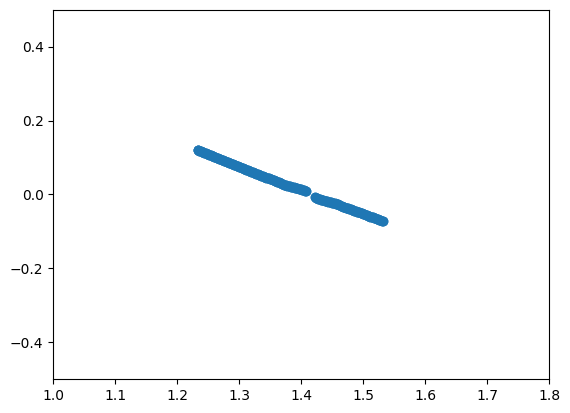

In [44]:
plt.ylim(-0.5,0.50)
plt.xlim(1.0,1.8)
plt.scatter(Varray, Epg)
plt.show()

In [24]:
def replace_outliers_with_nan(data):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN
    data_without_outliers = np.where((data < lower_bound) | (data > upper_bound), np.nan, data)
    
    return data_without_outliers

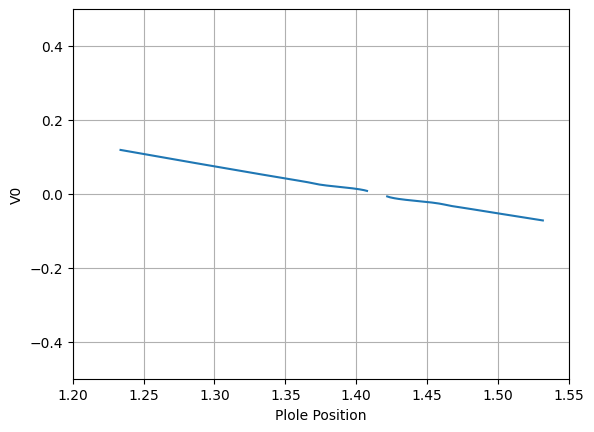

In [47]:
new_Ep = replace_outliers_with_nan(np.array(Epg))
x_interp = np.linspace(Varray.min(), Varray.max(), len(Varray))
Ep_interp = np.interp(x_interp, Varray, new_Ep)
plt.ylim(-0.5,0.50)
plt.xlim(1.2,1.55)
plt.plot(x_interp, Ep_interp)
plt.xlabel("Plole Position")
plt.ylabel("V0")
plt.grid()
plt.savefig("Pole position"+".png")
plt.show()

In [22]:
len(filtered_data)

246

In [23]:
len(Varray)

270